<b><font size="+2">Libraries</font></b>

In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from keras.datasets import fashion_mnist, cifar10, imdb

from sklearn.model_selection import train_test_split

# import layers and callbacks we may use (may not be a complete list)
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Model, Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras.utils import layer_utils

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Load the TensorBoard notebook extension
#%load_ext tensorboard


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())

------------
### Python version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.26.4
### Scikit-learn version: 1.4.2
### Tensorflow version: 2.16.1
------------


<b><font size="+2">Read Data</font></b>

In [2]:
# Define the directory containing the data
data_dir = 'Corn (Maize)'

# Define the categories (folder names)
categories = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

# Initialize lists to store filenames and labels
train_filenames = []
val_filenames = []
test_filenames = []
train_labels = []
val_labels = []
test_labels = []

# Load training data
for category_id, category in enumerate(categories):
    train_category_dir = os.path.join(data_dir, 'Train', category)
    for filename in os.listdir(train_category_dir):
        if filename.endswith('.JPG') or filename.endswith('.jpg'):  # Assuming images are jpg or png format
            train_filenames.append(os.path.join(train_category_dir, filename))
            train_labels.append(category_id)

# Load validation data
for category_id, category in enumerate(categories):
    val_category_dir = os.path.join(data_dir, 'Val', category)
    for filename in os.listdir(val_category_dir):
        if filename.endswith('.JPG') or filename.endswith('.jpg'):  # Assuming images are jpg or png format
            val_filenames.append(os.path.join(val_category_dir, filename))
            val_labels.append(category_id)

# Load test data
for category_id, category in enumerate(categories):
    test_category_dir = os.path.join(data_dir, 'Test', category)
    for filename in os.listdir(test_category_dir):
        if filename.endswith('.JPG') or filename.endswith('.jpg'):  # Assuming images are jpg or png format
            test_filenames.append(os.path.join(test_category_dir, filename))
            test_labels.append(category_id)

# Convert integer labels to one-hot encoded vectors
num_classes = len(categories)
y_train = to_categorical(train_labels, num_classes=num_classes)
y_val = to_categorical(val_labels, num_classes=num_classes)
y_test = to_categorical(test_labels, num_classes=num_classes)

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image from file
    img = load_img(image_path, target_size=(224, 224))
    # Convert image to numpy array
    img_array = img_to_array(img)
    # Preprocess the image (e.g., normalization)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Load and preprocess training images
X_train = np.array([load_and_preprocess_image(filename) for filename in train_filenames])

# Load and preprocess validation images
X_val = np.array([load_and_preprocess_image(filename) for filename in val_filenames])

# Load and preprocess test images
X_test = np.array([load_and_preprocess_image(filename) for filename in test_filenames])

# Check the shapes of the training, validation, and test data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (7316, 224, 224, 3)
Shape of y_train: (7316, 4)
Shape of X_val: (1645, 224, 224, 3)
Shape of y_val: (1645, 4)
Shape of X_test: (184, 224, 224, 3)
Shape of y_test: (184, 4)


<b><font size="+2">CNN Model</font></b>

In [3]:
def create_compile_cnn(input_shape=[224, 224, 3], num_outputs=4, verbose=False):
    cnn_model = Sequential(name='CNN')
    
    cnn_model.add(Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv1'))
    cnn_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv2'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool1'))
    
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv3'))
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv4'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool2'))
    
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv5'))
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv6'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool3'))
    
    cnn_model.add(Flatten(name='flatten'))
    
    cnn_model.add(Dense(64, activation='relu', kernel_initializer='lecun_uniform', name='dense1'))
    cnn_model.add(Dropout(0.25, name='drop1'))
    
    cnn_model.add(Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='dense2'))
    cnn_model.add(Dropout(0.25, name='drop2'))
    
    cnn_model.add(Dense(num_outputs, activation='softmax', name='output'))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    if verbose:
        cnn_model.summary()
    
    cnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return cnn_model

<b><font size="+2">Compile CNN</font></b>

In [4]:
cnn_model = create_compile_cnn(verbose=True)

c:\Users\yashh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool1 (MaxPooling2D)         │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2 (MaxPooling2D)         │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool3 (MaxPooling2D)         │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,620 (12.53 MB)

 Trainable params: 3,285,620 (12.53 MB)

 Non-trainable params: 0 (0.00 B)

<b><font size="+2">Fit Model</font></b>

In [5]:
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
max_epochs = 15
batch_size = 64
    
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

# Save the model
cnn_model.save('cnn.keras')

Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 406ms/step - accuracy: 0.5138 - loss: 0.9998 - val_accuracy: 0.8772 - val_loss: 0.3470
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - accuracy: 0.8946 - loss: 0.2808 - val_accuracy: 0.9441 - val_loss: 0.1386
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 339ms/step - accuracy: 0.9439 - loss: 0.1613 - val_accuracy: 0.9441 - val_loss: 0.1207
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 338ms/step - accuracy: 0.9467 - loss: 0.1516 - val_accuracy: 0.7891 - val_loss: 0.6184
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 336ms/step - accuracy: 0.9224 - loss: 0.2373 - val_accuracy: 0.9465 - val_loss: 0.1331
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 337ms/step - accuracy: 0.9556 - loss: 0.1221 - val_accuracy: 0.9666 - val_loss: 0.0967
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 339ms/step - accuracy: 0.9647 - loss: 0.0998 - val_accuracy: 0.9641 - val_loss: 0.1051
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 337ms/step - accuracy: 0.9687 - loss: 0

<b><font size="+2">MobileNetV2 Model</font></b>

In [6]:
# Load pre-trained MobileNetV2 model without the top (classification) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model with custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
max_epochs = 10
batch_size = 64
    
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

# Save the model
model.save('mobv2.keras')

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 77s 599ms/step - accuracy: 0.8643 - loss: 0.4457 - val_accuracy: 0.9635 - val_loss: 0.1063
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 535ms/step - accuracy: 0.9733 - loss: 0.0668 - val_accuracy: 0.9647 - val_loss: 0.1049
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 536ms/step - accuracy: 0.9813 - loss: 0.0463 - val_accuracy: 0.9672 - val_loss: 0.0864
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 537ms/step - accuracy: 0.9889 - loss: 0.0329 - val_accuracy: 0.9678 - val_loss: 0.0832
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 531ms/step - accuracy: 0.9918 - loss: 0.0254 - val_accuracy: 0.9696 - val_loss: 0.0917
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 530ms/step - accuracy: 0.9909 - loss: 0.0239 - val_accuracy: 0.9562 - val_loss: 0.1581
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 528ms/step - accuracy: 0.9941 - loss: 0.0184 - val_accuracy: 0.9720 - val_loss: 0.0979
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 61s 530ms/step - accuracy: 0.9982 - loss: 0

<b><font size="+2">Readable Predictions</font></b>

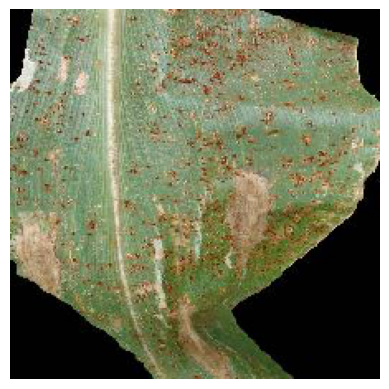

CNN MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions:
Class: Common Rust, Confidence: 1.0


MOBILEV2 MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predictions:
Class: Common Rust, Confidence: 0.840904712677002


In [10]:
# Define a function to make readable predictions
def readable_prediction(image_path, m, categories):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess the image as needed
    
    # Make predictions
    predictions = m.predict(img_array)
    
    # Print predictions in a readable form
    print('Predictions:')
    for pred in predictions:
        predicted_class_index = np.argmax(pred)
        confidence = np.max(pred)
        predicted_class_label = categories[predicted_class_index]
        print(f"Class: {predicted_class_label}, Confidence: {confidence}")

def get_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')        
    plt.show()

# The following is an image path for an image. It gives the confidence level of the prediction made for the image
image_path = 'Corn (Maize)/Val/Common Rust/RS_Rust 1659.JPG'
categories = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

get_image(image_path)

print('CNN MODEL:')
readable_prediction(image_path, cnn_model, categories)
print('\n')
print('MOBILEV2 MODEL:')
readable_prediction(image_path, model, categories)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.9803 - loss: 0.1030
Test accuracy: 0.9728260636329651
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
Confusion Matrix for MobileNetV2:
[[40  0  0  1]
 [ 0 48  0  0]
 [ 0  0 47  0]
 [ 4  0  0 44]]


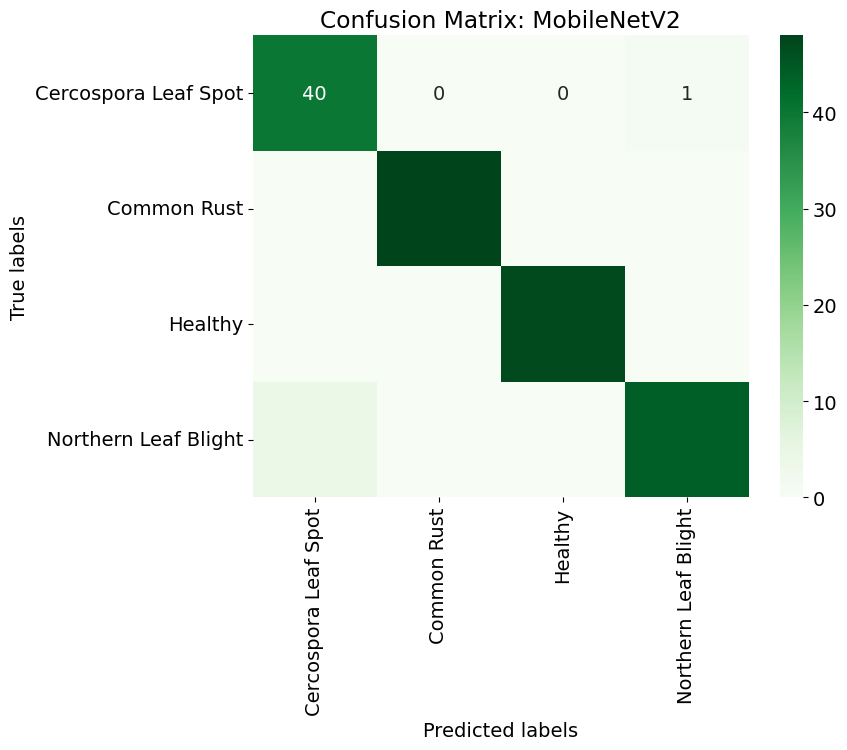

In [26]:
# Assuming 'model' is your trained model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to integer labels
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for MobileNetV2:')
print(conf_matrix)

# Labels for the classes
class_labels = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

# Create a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: MobileNetV2')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9313 - loss: 0.3169
Test accuracy: 0.945652186870575
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Confusion Matrix for CNN:
[[35  0  0  6]
 [ 0 48  0  0]
 [ 0  0 47  0]
 [ 2  1  1 44]]


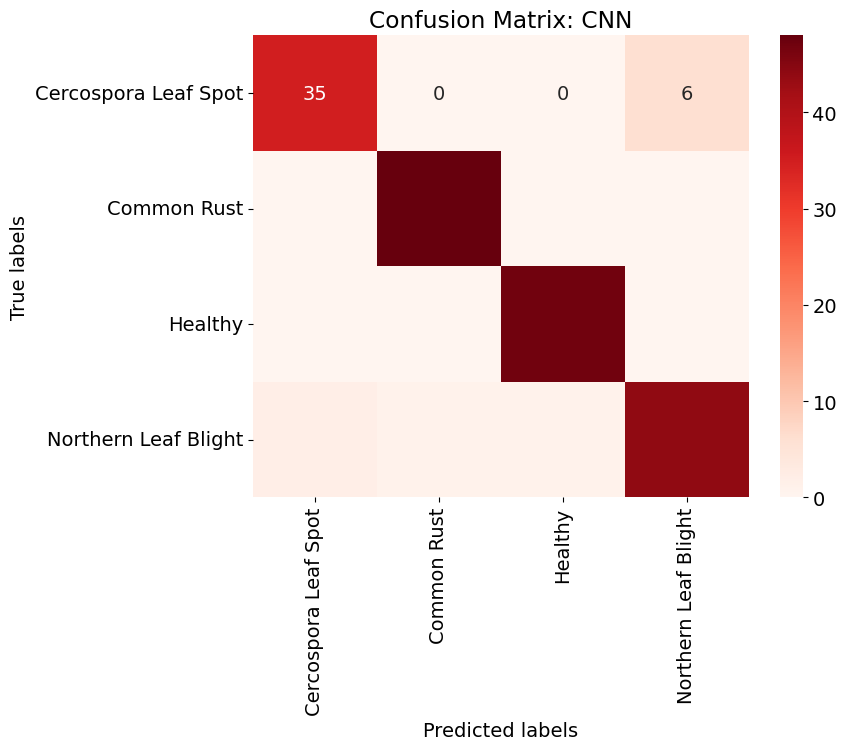

In [27]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on test data
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to integer labels
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for CNN:')
print(conf_matrix)

# Labels for the classes
class_labels = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

# Create a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: CNN')
plt.show()